In [37]:
#import libraries
import pandas as pd
import numpy as np
import time
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import nltk
import ssl
import re
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn import feature_selection, feature_extraction, naive_bayes, pipeline, metrics
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K


#command to install pip packages in jupyter
#!{sys.executable} -m pip install [package]
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#command to install pip packages in jupyter
#!{sys.executable} -m pip install [package]


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [3]:
#load preprocessed data (tokenized, lemmatized)
df_small = pd.read_csv('spectrum.csv')
df_small = df_small.dropna()

#split data 
train, test = sklearn.model_selection.train_test_split(df_small, test_size=0.3)

In [4]:
#function to create lists of unigrams
def unigrams(corpus):
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [" ".join(lst_words[i:i+1]) 
                     for i in range(0, len(lst_words), 1)]
        lst_corpus.append(lst_grams)
    return lst_corpus

In [5]:
#fit unigrams to train data
corpus_train = train['body']
lst_corpus_train = unigrams(corpus_train)

#fit bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus_train, 
                 min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus_train], 
                min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [6]:
#fit vord2vec
start = time.process_time()
nlp = gensim.models.word2vec.Word2Vec(lst_corpus_train, vector_size=300,
        window=8, min_count=2, sg=1, epochs=30)
end = time.process_time()
print(end-start)nlp

2363.306688372


In [48]:
#save model 
nlp.save("word2vec_keras_working.model")

#load model 
nlp = Word2Vec.load("word2vec_keras_working.model")

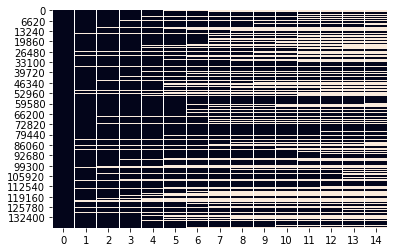

In [39]:
#define tokenizer
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

#tokenize train text
tokenizer.fit_on_texts(lst_corpus_train)
dic_vocabulary = tokenizer.word_index

#create sequence
lst_text2seq_train = tokenizer.texts_to_sequences(lst_corpus_train)

#padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq_train, 
                    maxlen=15, padding="post", truncating="post")

#plot results
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

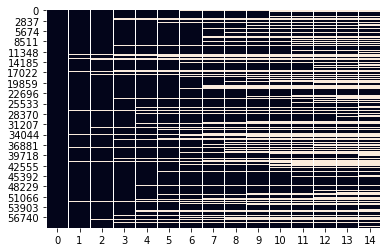

In [40]:
#same for test set
#test unigrams
corpus_test = test["body"]
lst_corpus_test = unigrams(corpus_test)

#grams
#lst_corpus_test = list(bigrams_detector[lst_corpus_test])
#lst_corpus_test = list(trigrams_detector[lst_corpus_test])

#text to sequence with the fitted tokenizer
lst_text2seq_test = tokenizer.texts_to_sequences(lst_corpus_test)

#adding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq_test, maxlen=15,
             padding="post", truncating="post")

#plot results
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [41]:
#matrix = vocabulary x vector size
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

#update row with vector if word exists in the model
for word,idx in dic_vocabulary.items():
    try:
        embeddings[idx] =  nlp.wv[word]
    except:
        pass

In [42]:
#code attention layer
#source https://arxiv.org/abs/1409.0473
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

#input
x_in = layers.Input(shape=(15,))

#embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)

#apply attention
x = attention_layer(x, neurons=15)

#2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

#final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)

#compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 15, 300)      61075200    ['input_2[0][0]']                
                                                                                                  
 permute_1 (Permute)            (None, 300, 15)      0           ['embedding_1[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 300, 15)      240         ['permute_1[0][0]']              
                                                                                            

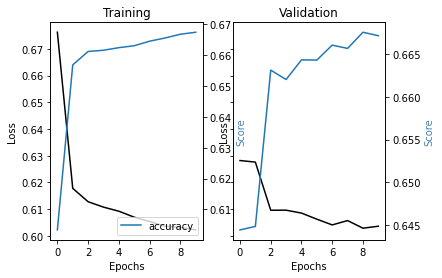

In [43]:
#encode y
y_train = train['spectrum']
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])


#train model
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)


#plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()


In [44]:
#free memory
import gc
gc.collect()

155372

In [45]:
#test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [46]:
y_test = test['spectrum']
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

Accuracy: 0.67
Auc: 0.74
Detail:
              precision    recall  f1-score   support

        left       0.67      0.67      0.67     29763
       right       0.67      0.67      0.67     29811

    accuracy                           0.67     59574
   macro avg       0.67      0.67      0.67     59574
weighted avg       0.67      0.67      0.67     59574



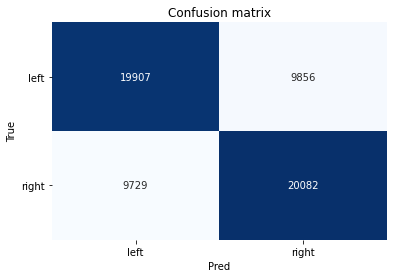

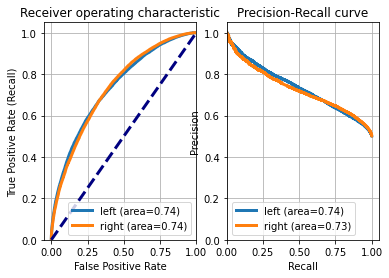

In [47]:
metrics = sklearn.metrics

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()